In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import albumentations as A

In [2]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

In [3]:
# same seed
torch.manual_seed(0)

In [4]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [5]:
# CUDA
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# helper function for dataset
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    # only have ships
    return 1 

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "xml")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))


        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}

        
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        
        ax.add_patch(rect)

    plt.show()

In [7]:
class ShipDataset:
    def __init__(self, path, transform=None):
        self.path = path
        self.files = list(sorted(os.listdir("annotations_yolo/")))
        self.transform = transform
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_image = self.files[idx][:-3] + 'jpg'
        file_label = self.files[idx][:-3] + 'xml'

        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        
        #print(img_path)
        # Read an image with OpenCV, gray scale
        image = cv2.imread(img_path,0)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image/255.0
        target = generate_target(label_path)

        #start_t = time.time()
        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = torch.Tensor(transformed['image'])
            target = {'boxes':torch.Tensor(transformed['bboxes']).reshape(-1,4), 'labels':torch.Tensor(transformed['labels'])}
        else:
            image = torch.tensor(image,dtype=torch.float32)
        
        image = torch.unsqueeze(image, dim=0)
            
        return image, target #, total_time

In [8]:
transform = A.Compose([
    A.Resize(800,800),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=0.5),
                          albumentations.RandomRotate90(p=0.5),
                          albumentations.VerticalFlip(p=0.5)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=0.5),
                          #albumentations.GaussNoise(p=0.5,var_limit=(0,1))                 
    ], p=1)
    
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=[]))

In [9]:
dataset = ShipDataset(
    path = 'images/',
    #transform=transform
)
len(dataset)

1859

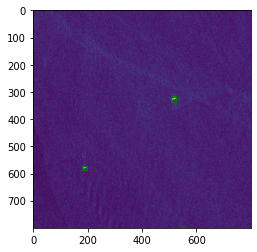

In [10]:
img, annotation = dataset[0]
plot_image_from_output(img, annotation)

In [11]:
train_set, val_set = torch.utils.data.random_split(dataset, [1400,459],)
len(train_set), len(val_set)

(1400, 459)

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [13]:
batch_size = 4

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,collate_fn=collate_fn)

In [ ]:
#fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes = 1, pretrained=False, pretrained_backbone = True)

In [ ]:
# load a model pre-trained on COCO
fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (ship) + background
# get number of input features for the classifier
in_features = fasterRCNN.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
fasterRCNN.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

## Training

In [ ]:
num_epochs = 1
fasterRCNN.to(device)
    
# parameters
params = [p for p in fasterRCNN.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.1)

len_dataloader = len(train_loader)
all_loss = []
# about 4 min per epoch on Colab GPU
for epoch in range(num_epochs):
    start = time.time()
    fasterRCNN.train()

    i = 0    
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        
        #print(targets)
        

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(images)
        loss_dict = fasterRCNN(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()

        torch.nn.utils.clip_grad_norm_(params,max_norm=2.0)
        optimizer.step()
        
        epoch_loss += losses 
    all_loss.append(epoch_loss)
    if epoch % 5 == 0:
        print("Epoch #: {0}, Loss: {1}, Time: {2}".format(epoch, epoch_loss.item(),time.time() - start))
        

In [ ]:
torch.save(fasterRCNN.state_dict(), "models/fasterTest.pt")

### Inference

In [15]:
fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 2  # 1 class (ship) + background
# get number of input features for the classifier
in_features = fasterRCNN.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
fasterRCNN.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
fasterRCNN.load_state_dict(torch.load("models/fasterTest.pt"))
fasterRCNN.eval()
fasterRCNN.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [16]:
def plot_image_from_output2(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #select idx which meets the threshold
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [17]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(val_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(fasterRCNN, im, 0.0001)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 115/115 [00:30<00:00,  3.74it/s]


Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Inde

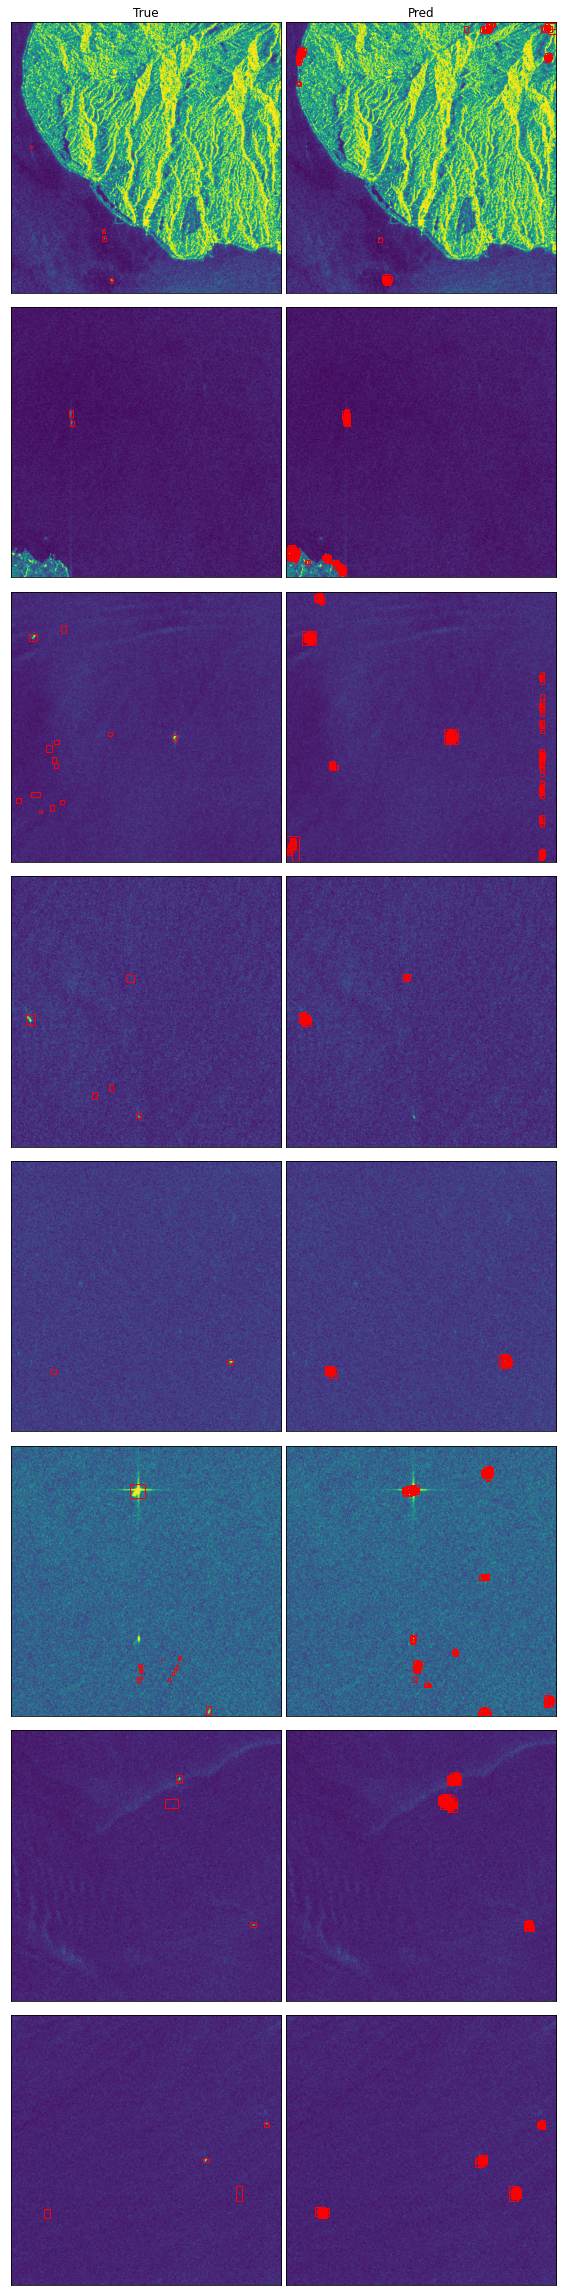

In [18]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in val_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output2(im[sample_i], annot[sample_i])
        try:
            axes[(pos)//2, 1-((pos)%2)].imshow(img)
        except:
            print("Index Error")
        for rect in rects:
            try:
                axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
            except:
                print("Index Error")
        img, rects = plot_image_from_output2(im[sample_i], preds_adj_all[batch_i][sample_i])
        try:
            axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        except:
            print("Index Error")
        for rect in rects:
            try:
                axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)
            except:
                print("Index Error")
        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()


In [ ]:
def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   
 
        annotations = targets[sample_i]  # actual
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: 
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index] 
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 


In [ ]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))] 
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))
print(f'mAP : {mAP}')
print(f'AP : {AP}')

In [ ]:
"Recall: {0} and Precision: {1}".format(recall, precision)